# llc4320 drifters spectra

Computes periodograms over rolling windows

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5232179.datarmor0/parcels-55081/libparcels_random_e9a34bb9-0f01-4f69-8bba-ef9ad8c4991a.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    #cluster = PBSCluster(cores=28, processes=14)
    cluster = PBSCluster(cores=14, processes=7)
    w = cluster.scale(jobs=8)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.241:54290 Dashboard: http://10.148.0.241:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## load data

In [14]:
#root_dir = '/home1/datawork/aponte/parcels/'
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, 
                      parquets=['trajectory', 'trajectory_mean'],
                      #parquet_kwargs=dict(engine="pyarrow"),
                     )
df = p['trajectory_mean']

In [15]:
# add time in hours
df = df.rename(columns={'time': 'date'})

# filter out bad data (there are some with negative trajectory and NaN)
df = df.dropna()

time_unit = pd.Timedelta('1H')
t_start = df.date.min().compute()
t_end = df.date.max().compute()
df['time'] = (df['date'] - t_start)/time_unit # safer to work with time in seconds

# Should check time sampling more thoroughly at some points
# we know there are many duplicates, 
# some may have similar dates/trajectory but different data

df = df.persist()

# 58GB on disk, 75GB in memory

df.head()

,date,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,mean_sea_level,mean_zonal_velocity,mean_temperature,mean_meridional_velocity,mean_salinity,time
trajectory,,,,,,,,,,,,,,,
39000000,2011-11-15,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0,0.060997,-0.002461,4.279537,-0.006017,33.194778,0.0
39000001,2011-11-15,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0,0.075155,-0.091730,4.326020,0.050204,33.139637,0.0
39000002,2011-11-15,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0,0.169278,-0.203138,4.161501,0.209887,32.961617,0.0
39000003,2011-11-15,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0,0.242839,-0.075768,3.679666,0.064889,32.712219,0.0
39000004,2011-11-15,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0,0.222071,-0.006189,3.151162,0.057710,32.573410,0.0


In [21]:
def print_info(df):
    partition_size = df.memory_usage_per_partition().compute().loc[0]
    print("Partition size = {:.0f} MB".format(partition_size/1e6))

    df_size = df.memory_usage().compute().sum()
    print("Dataset global size = {:.0f} GB".format(df_size/1e9))

    num_drifters = len(df.index.unique().compute())
    print("Total number of drifters (trajectory) = {:d}".format(num_drifters))
    return num_drifters

num_drifters = print_info(df)

Partition size = 100 MB
Dataset global size = 77 GB
Total number of drifters (trajectory) = 96710


In [22]:
num_drifters_original = print_info(p['trajectory'].dropna())

Partition size = 100 MB
Dataset global size = 40 GB
Total number of drifters (trajectory) = 100065


In [18]:
# bad data point: negative trajectory id and NaN values for all variables
# are there other for 'time' data?
if False:
    _df = df.reset_index()
    _df = _df[_df.trajectory<0].compute()
    print(_df.index.size)
    _df.head()

---

## start processing

In [23]:
def process_uv(lon, lat, u, v, N, dt, **kwargs):
    ''' Wraps spectral calculation: add complex velocity
    Assumes the time series is regularly sampled
    
    Parameters:
    -----------
        u, v: pd.Series
            zonal, meridional index by time (in days)
        N: int,
            length of the spectrum
        dt: float
            Time sampling in days
        **kwargs:
            passed to mit_equinox.drifters.get_spectrum
    '''
    if lon is None:
        uv = None
    else:
        uv = u + 1j*v
    return dr.get_spectrum(uv, N, dt=dt, **kwargs)

def process_lonlat(lon, lat, N, dt, **kwargs):
    ''' Wraps spectral calculation: add complex velocity
    Assumes the time series is regularly sampled
    
    Parameters:
    -----------
        lon,lat: pd.Series
            Longitude index by time (in days)
        N: int,
            length of the spectrum
        dt: float
            Time sampling in days
        **kwargs:
            passed to mit_equinox.drifters.get_spectrum
    '''
    if lon is None:
        uv = None
    else:
        # compute displacements
        lon1, lat1 = lon.shift(periods=-1), lat.shift(periods=-1)
        u = dr.haversine(lon, lat, lon1, lat)*1e3 *np.sign(lon1-lon) /dt/86400
        v = dr.haversine(lon, lat, lon, lat1)*1e3 *np.sign(lat1-lat) /dt/86400
        u = pd.Series(u, index=lon.index).fillna(method='ffill')
        v = pd.Series(v, index=lon.index).fillna(method='ffill')
        uv = u + 1j*v
    return dr.get_spectrum(uv, N, dt=dt, **kwargs)

def process_real(v, N, dt, **kwargs):
    ''' Wraps spectral calculation of a real variable (e.g. temperature, ...)
    Assumes the time series is regularly sampled
    
    Parameters:
    -----------
        lon,lat: pd.Series
            Longitude index by time (in days)
        N: int,
            length of the spectrum
        dt: float
            Time sampling in days
        **kwargs:
            passed to mit_equinox.drifters.get_spectrum
    '''
    _kwargs = dict(return_onesided=True)
    _kwargs.update(kwargs)
    #N = int(N/2)+1
    return dr.get_spectrum(v, N, dt=dt, **_kwargs)

## velocity

**Cell below is the computationnally intensive part**

Peaks at 220GB of RAM

In [31]:
mean = 2 # 0=raw time series, 1=raw-mean, 2=mean

T_str = '60D' # days
dt = '1H' # sampling

N = int(pd.Timedelta(T_str)/pd.Timedelta(dt)) # output size
T = pd.Timedelta(T_str)/time_unit # must be in the same units than time

columns = ['lon', 'lat']
if mean==0:
    columns = columns + ['zonal_velocity', 'meridional_velocity']    
elif mean==1:
    df["zonal_velocity_prime"] = df["zonal_velocity"] - df["mean_zonal_velocity"]
    df["meridional_velocity_prime"] = df["meridional_velocity"] - df["mean_meridional_velocity"]
    columns = columns + ['zonal_velocity_prime', 'meridional_velocity_prime']
elif mean==2:
    columns = columns + ['mean_zonal_velocity', 'mean_meridional_velocity']

df_chunked = (df
              .groupby("trajectory")
              .apply(dr.time_window_processing,
                     process_uv,
                     columns,
                     T,
                     N,
                     id_label='trajectory',
                     dt=dt,
                    )
              .persist()
             )

# lon/lat processing
#df_chunked = (df
#              .groupby(df.index)
#              .apply(dr.time_window_processing,
#                     process_lonlat,
#                     ['lon', 'lat'],
#                     T, 
#                     N,
#                     id_label='trajectory',
#                     dt=dt,
#                    )
#              .persist()
#             )

#note: grouping on index has not allways been working, 
# may need to reset_index and group on column

# the dataframe partitions has a multi-index: id and window central time (unknow name for now)
# we first transform the index corresponding to time into a regular column.
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )
df_chunked = df_chunked.drop(columns='id')
df_chunked.head()

<ipython-input-31-9d4cbb9bfa44>:19: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = (df


,time,lon,lat,0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,...,-0.16666666666666666,-0.15,-0.13333333333333333,-0.11666666666666667,-0.1,-0.08333333333333333,-0.06666666666666667,-0.05,-0.03333333333333333,-0.016666666666666666
trajectory,,,,,,,,,,,,,,,,,,,,,
2000163,720.0,-29.703247,-66.041312,0.023505,0.004142,0.000076,0.000008,0.000002,7.424193e-08,1.631206e-08,...,6.365846e-08,2.280200e-06,0.000006,0.000003,0.000005,0.000015,0.000019,0.000022,0.000051,0.008226
2000163,1440.0,-30.502333,-65.684217,0.020090,0.004841,0.000023,0.000036,0.000034,9.885860e-06,1.568042e-08,...,1.237542e-05,5.750943e-06,0.000007,0.000018,0.000023,0.000035,0.000035,0.000030,0.000123,0.005291
2000163,2160.0,-30.571816,-65.382260,0.020071,0.004037,0.000045,0.000065,0.000043,2.183200e-06,6.380951e-07,...,2.102988e-07,7.929698e-08,0.000002,0.000005,0.000005,0.000003,0.000004,0.000004,0.000015,0.005765
2000163,2880.0,-30.551882,-65.032618,0.022674,0.005251,0.000021,0.000093,0.000022,1.113861e-05,1.368663e-05,...,3.539268e-06,1.415246e-06,0.000005,0.000013,0.000028,0.000003,0.000017,0.000059,0.000016,0.006557
2000163,3600.0,-30.953843,-64.618538,0.026906,0.003922,0.000015,0.000105,0.000213,4.549341e-05,2.596576e-05,...,1.578661e-06,4.190219e-06,0.000001,0.000057,0.000046,0.000115,0.000232,0.000002,0.000023,0.009529


In [32]:
# store to parquet
parquet = 'spectra_raw_uv_T{}_mean{}'.format(int(T_str[:-1]), mean)

df_chunked.columns = df_chunked.columns.astype(str) # fastparquet does not allow float column names
p.store_diagnostic(parquet, df_chunked, overwrite=True)

No reindexing
create new archive: /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_raw_uv_mean2


## tracers

In [8]:
v = 'temperature'
#v = 'salinity'
#v = 'sea level'

In [9]:
T = '60D' # days
dt = '1H' # sampling

N = int(pd.Timedelta(T)/pd.Timedelta(dt)) # output size
T = pd.Timedelta(T)/time_unit # must be in the same units that time

df_chunked = (df
              .groupby(df.index)
              .apply(dr.time_window_processing,
                     process_real,
                     ['temperature'],
                     T, 
                     N,
                     id_label='trajectory',
                     dt=dt,
                    )
              .persist()
             )

#note: grouping on index has not allways been working, 
# may need to reset_index and group on column

# the dataframe partitions has a multi-index: id and window central time (unknow name for now)
# we first transform the index corresponding to time into a regular column.
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )
df_chunked = df_chunked.drop(columns='id')
df_chunked.head()

<ipython-input-9-34f47b809e2b>:7: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = (df


,time,lon,lat,0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,...,11.85,11.866666666666667,11.883333333333333,11.9,11.916666666666666,11.933333333333334,11.95,11.966666666666667,11.983333333333333,12.0
trajectory,,,,,,,,,,,,,,,,,,,,,
1000207,120.0,-26.770351,-75.351169,137.903870,69.322136,0.001280,0.000196,0.001208,0.000353,0.000326,...,5.996031e-08,4.706557e-08,3.223492e-08,4.436894e-08,6.057635e-08,1.644082e-09,4.761263e-08,3.025492e-08,5.703403e-08,1.149781e-10
1000207,150.0,-29.163544,-76.060546,139.656174,69.882080,0.000009,0.000044,0.000006,0.000006,0.000012,...,1.939989e-09,7.530394e-10,3.966165e-10,3.778581e-10,1.407654e-09,9.570944e-10,1.940154e-09,6.307867e-10,9.252107e-10,1.408482e-11
1000207,180.0,-32.524974,-76.693448,139.952423,69.859123,0.000092,0.000073,0.000067,0.000045,0.000032,...,7.228029e-09,1.289028e-08,1.738962e-08,1.390623e-08,1.360081e-08,9.292967e-09,5.717919e-09,1.147936e-08,7.722355e-09,1.932782e-09
1000207,210.0,-36.271188,-77.390706,141.131058,70.694962,0.000139,0.000049,0.000014,0.000015,0.000016,...,2.185479e-08,4.135648e-09,3.900247e-09,8.802009e-10,7.272233e-09,1.485804e-09,1.739498e-09,9.323539e-09,7.913636e-09,2.760624e-09
1000207,240.0,-39.300011,-77.743990,141.318054,70.638672,0.000011,0.000003,0.000005,0.000003,0.000003,...,1.353111e-10,3.874479e-10,2.696638e-09,6.601137e-11,8.830375e-10,2.131494e-10,1.364898e-09,1.423898e-09,1.730927e-09,7.772520e-10


In [10]:
# store to parquet
df_chunked.columns = df_chunked.columns.astype(str) # fastparquet does not allow float column names
p.store_diagnostic('spectra_raw_'+v.replace(" ","-"), df_chunked, overwrite=True)

No reindexing
deleting existing archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_raw_temperature
create new archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_raw_temperature


--- 

## inspect result

**Could move to another notebook from here**

In [33]:
# read parquet file
df_chunked = p.load_diagnostic("spectra_raw_uv_mean0")

df_chunked = df_chunked.persist()
df_chunked.head()

,time,lon,lat,0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,...,-0.16666666666666666,-0.15,-0.13333333333333333,-0.11666666666666667,-0.1,-0.08333333333333333,-0.06666666666666667,-0.05,-0.03333333333333333,-0.016666666666666666
trajectory,,,,,,,,,,,,,,,,,,,,,
2000163,720,-29.703247,-66.041312,8.338802e-12,1.207717e-11,1.074234e-11,2.495221e-12,1.672306e-13,1.280286e-12,2.492413e-13,...,7.335028e-14,1.219433e-12,5.719692e-13,4.892385e-13,2.747133e-12,2.262332e-12,8.333393e-13,4.678929e-12,5.080804e-12,2.254243e-12
2000163,1440,-30.502333,-65.684217,2.001266e-12,9.559546e-13,4.979303e-13,3.239861e-12,4.955153e-12,2.334991e-12,2.567932e-12,...,1.118752e-12,1.244722e-12,4.486867e-12,6.339103e-12,9.273925e-12,6.514415e-12,3.256144e-12,5.957223e-12,8.124006e-12,5.227717e-12
2000163,2160,-30.571816,-65.382260,2.777798e-12,5.108839e-12,4.283840e-12,4.097663e-12,7.824161e-12,3.595292e-12,5.920042e-14,...,3.827290e-12,1.720933e-12,1.722433e-12,2.310255e-12,7.717401e-13,5.674966e-12,1.678686e-11,1.526324e-11,1.214662e-11,5.212905e-12
2000163,2880,-30.551882,-65.032618,7.659140e-13,9.206635e-13,6.061808e-12,1.091933e-11,9.140986e-12,2.269597e-12,4.053166e-12,...,2.566797e-12,7.817943e-13,1.932491e-12,9.212856e-12,9.355600e-12,4.999138e-12,2.244695e-11,2.096962e-11,4.396242e-12,1.086125e-12
2000163,3600,-30.953843,-64.618538,3.495475e-12,8.408760e-13,6.138240e-12,4.706817e-12,6.741197e-12,2.776728e-12,2.085372e-12,...,1.221923e-12,5.122003e-13,1.192730e-13,3.598959e-12,9.599307e-12,1.214984e-11,8.575630e-12,1.337666e-12,1.286681e-12,4.747888e-12


7920


<AxesSubplot:>

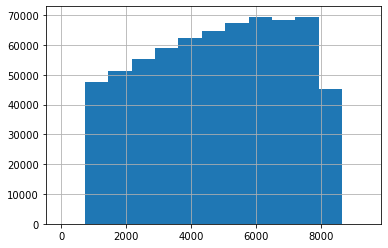

In [36]:
t = df_chunked['time'].compute()
print(t.max())
t.hist(bins=np.arange(0,400*24,30*24))

In [37]:
# bin geographically
lat_bins = np.arange(-60, 60, 1.)
lat_idx = pd.IntervalIndex.from_breaks(lat_bins)
df_chunked['lat_cut'] = df_chunked['lat'].map_partitions(pd.cut, bins=lat_bins)

E = df_chunked.groupby(['lat_cut']).mean().compute()

#Converting pandas dataframe in xarray dataset:
ds = (pd.melt(E.set_index(E.index.map(lambda v: v.mid))
              .drop(columns=['time','lon','lat'])
              .reset_index(), id_vars=['lat_cut',], var_name='frequency')
              .rename(columns={'lat_cut': 'lat_bins', 'value': 'E'})
     ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()
ds['frequency'] = ds['frequency'].astype(float)
ds = ds.sortby('frequency')

# store diagnostic (not done here)
#p.store_diagnostic('spectra_lat', ds, overwrite=True)

# may be loaded with 
#ds = p.load_diagnostic('spectra_lat.zarr')

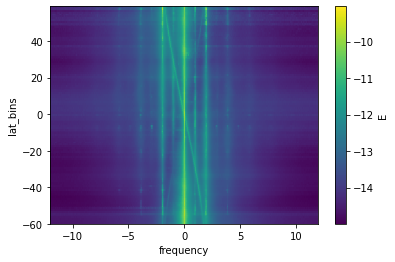

In [39]:
np.log10(ds.E).plot()

## Close cluster

In [ ]:
#cluster.scale(jobs=10)

In [40]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
